In [43]:
%pip install toolz
%pip install composable

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import polars as pl
import polars.selectors as cs
import numpy as np
from toolz.dicttoolz import valmap
import composable.records as rec
from composable.object import obj
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression

## Review - Cross Validation

Cross validation is a more robust method of measuring performance and comparing models, as it uses all the data to both train and test the model.  In this section, we will look at

1. How to compute a single performance metric using `cross_val_score`,
2. Compute multiple metrics over the same split using ``, and
3. Compare two or more models over the same CV split.

### What is cross validation?

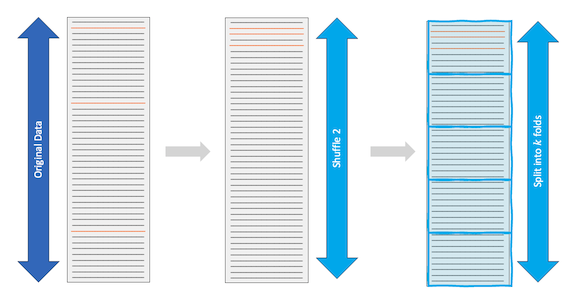

### Benefits of Cross Validation

- **Objective.** Provides a more reliable estimate of model performance
- **Overfitting.** Reduces the risk of overfitting
- **Data Efficiency.** Makes better use of limited data
- **Model Selection.** Helps in model selection and hyperparameter tuning


## Cross validation for regression

### Home prices data set

For this exercise, we will be using the `HomePrices.csv` data set that I use in STAT 310, which is available in the `data` folder.

In [3]:
(homes := 
 pl.read_csv('./sample_data/HomePrices.csv')
)

MLS,CurrentPrice,SquareFeet,Bedrooms,Bathrooms,Garage,YearBuilt,LotSize,Taxes,DaysonMarket,OriginalPrice
i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64
4036305,119900,1936,3,2.0,2,1920,7000,1448,151,129900
4034062,73700,1696,2,1.0,1,1916,6860,664,245,73700
4038971,104500,1196,3,2.0,2,1890,7000,1216,51,104500
4034561,114900,864,2,1.0,2,1940,5000,1092,218,114900
4035526,215000,3300,4,3.0,2,2001,null,2850,174,215000
…,…,…,…,…,…,…,…,…,…,…
4039546,119000,1056,2,2.0,1,1977,1848,1364,23,119000
4039325,104900,1992,3,1.0,0,1890,4800,1516,35,104900
4037376,139500,1314,2,2.0,2,1995,6600,1694,160,149500


#### Splitting the target and features

* **Goal.** Predict the `CurrentPrice` with the remaining columns.
* **Note.** Switch to `pandas` dataframes to avoid possible errors.

In [4]:
(X_homes := 
 homes
 .drop('CurrentPrice')
 .to_pandas()
)

,MLS,SquareFeet,Bedrooms,Bathrooms,Garage,YearBuilt,LotSize,Taxes,DaysonMarket,OriginalPrice
0,4036305,1936,3.0,2.0,2.0,1920.0,7000.0,1448.0,151,129900
1,4034062,1696,2.0,1.0,1.0,1916.0,6860.0,664.0,245,73700
2,4038971,1196,3.0,2.0,2.0,1890.0,7000.0,1216.0,51,104500
3,4034561,864,2.0,1.0,2.0,1940.0,5000.0,1092.0,218,114900
4,4035526,3300,4.0,3.0,2.0,2001.0,NaN,2850.0,174,215000
...,...,...,...,...,...,...,...,...,...,...
202,4039546,1056,2.0,2.0,1.0,1977.0,1848.0,1364.0,23,119000
203,4039325,1992,3.0,1.0,0.0,1890.0,4800.0,1516.0,35,104900
204,4037376,1314,2.0,2.0,2.0,1995.0,6600.0,1694.0,160,149500
205,4029172,2288,3.0,3.0,2.0,1988.0,2176.0,1910.0,479,179900


In [5]:
(y_homes := 
 homes
 .get_column('CurrentPrice')
 .to_numpy()
)


array([119900,  73700, 104500, 114900, 215000, 169500,  39500, 249900,
        77500, 126900, 111900,  99900,  92900, 152400,  99900, 135900,
        92900, 119900, 104900, 137500,  53900, 284500,  94900, 159900,
       129900, 116900,  69900, 117000, 159900, 169900, 168541,  79900,
        69900, 134900,  90000,  94900, 209900, 137000, 234900, 355000,
       229000, 100000, 125000, 312900,  44200,  68500,  55000, 129900,
       169900, 219000,  74900, 134900, 125000, 129000, 159900,  79900,
        98000,  79000, 109900, 130900, 139900,  87900,  97500, 139900,
       159500,  79900, 137500,  49900, 104900, 119000, 177072,  95000,
       131900,  69900,  67500,  92900,  84900,  99900, 100000, 179000,
        77500, 104900, 163541, 119500,  79000, 243375, 119900, 145000,
       117900, 231500, 149900,  99900,  89900, 349000, 114900, 112900,
       206900, 134900,  91999,  87975, 269900,  78900, 109900, 116000,
       132840,  84200, 119900, 169900,  92000, 169500, 119500,  89900,
      

### Measuring regression performance via cross-validation

Cross validation is an alternative to evaluating performance via training-test split.  Cross validation has the advantage of using every point both to build the model and evaluate its performance, at the cost of added complexity.  Luckily, `sklearn` makes scoring by cross-validation relatively pain free.

**Important notes.** 

1. By default, `cross_val_score` uses statified CV, which is the best approach, especially in problems with class imbalance.  This assures that all folds will have an equal number of positive and negative cases.
2. The default measure is `explained_variance_score`, better known as $R^2$ in a statistical setting.

See [the sklearn model evaluation documentation](https://scikit-learn.org/stable/modules/model_evaluation.html) for a list of available scores.

In [6]:
(model :=
 make_pipeline(SimpleImputer(),
               LinearRegression()
               )
)

,steps,"[('simpleimputer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,fit_intercept,True


In [13]:
(single_cv_R_sqr :=
    cross_val_score(model, X_homes, y_homes, cv = 10) # Uses R^2 by default
).mean()

np.float64(0.9535829902674923)

#### Note on scoring returning negative values

When using MSE and MAE, `sklearn` returns the negative of these scores to maintain a "bigger is better" approach to scoring.  To get the usual values, simply multiply by `-1`

In [15]:
(single_cv_mae :=
    cross_val_score(model, X_homes, y_homes, scoring = 'neg_mean_absolute_error')
).mean()

np.float64(-8521.598236141073)

In [16]:
-1*single_cv_mae.mean()
# INTERPRET: The average absolute error is $8,521

np.float64(8521.598236141073)

In [18]:
(single_cv_mspe :=
    cross_val_score(model, X_homes, y_homes, scoring = 'neg_mean_squared_error')
).mean()

np.float64(-147331714.86363968)

In [19]:
(-1*single_cv_mspe.mean())**0.5
# INTERPRET: The "average" error is $12,138i

np.float64(12138.02763481941)

### Computing multiple cross validation scores 

We can use the `cross_validate` function to compute a number of metrics over the folds.

In [20]:
(cv_results := 
 cross_validate(model, X_homes, y_homes, 
                scoring = ['explained_variance', 
                           'neg_mean_absolute_error', 
                           'neg_mean_squared_error']
               )
)

{'fit_time': array([0.00290704, 0.00318003, 0.00201392, 0.00222087, 0.00237012]),
 'score_time': array([0.00211787, 0.00130677, 0.00126314, 0.00124717, 0.00112677]),
 'test_explained_variance': array([0.95659314, 0.94331173, 0.95477371, 0.97558105, 0.96657211]),
 'test_neg_mean_absolute_error': array([-8201.51563029, -9289.2133322 , -8754.26207272, -8046.57404713,
        -8316.42609836]),
 'test_neg_mean_squared_error': array([-1.79728833e+08, -1.44172302e+08, -1.55864818e+08, -1.08961926e+08,
        -1.47930694e+08])}

In [23]:
(cv_results
 >> rec.drop(['fit_time', 'score_time'])                            # Get rid of unneeded key,val pairs
 >> rec.map(np.mean)                                                # Maps np.mean to all values
 >> rec.apply(                                                      # Apply functions to values by key
              test_neg_mean_absolute_error = lambda x: -1*x,          # Compute the opposite
              test_neg_mean_squared_error  = lambda x: (-1*x)**0.5    # Square-root of the opposite
              )

)

{'test_explained_variance': np.float64(0.9593663480246176),
 'test_neg_mean_absolute_error': np.float64(8521.598236141073),
 'test_neg_mean_squared_error': np.float64(12138.02763481941)}

## Randomness and repeatability in cross validation

- Cross validation involves random shuffling of the data
- Results can differ each time you run it
- Setting a random seed ensures repeatable results (Use random.org to generate a random seed)
- Pass the seed to `cross_val_score`, `cross_validate` or `GridSearchCV` via a `KFold` object

In [27]:
(folds :=
 KFold(n_splits=5, shuffle=True, random_state= 17132)
)

KFold(n_splits=5, random_state=17132, shuffle=True)

In [30]:
(cv_results := 
 cross_validate(model, X_homes, y_homes,
                cv = folds,                                         # Random but repeatable
                scoring = ['explained_variance', 
                           'neg_mean_absolute_error', 
                           'neg_mean_squared_error']
               )
 >> rec.drop(['fit_time', 'score_time'])                            
 >> rec.map(np.mean)                                                
 >> rec.apply(                                                      
              test_neg_mean_absolute_error = lambda x: -1*x,        
              test_neg_mean_squared_error  = lambda x: (-1*x)**0.5  
              )

)

{'test_explained_variance': np.float64(0.9552300554330089),
 'test_neg_mean_absolute_error': np.float64(8531.402127067191),
 'test_neg_mean_squared_error': np.float64(12420.911174912482)}

## <font color="red">Exercise 2.6.1</font>

**Tasks.**
1. Build a pipeline that includes a `SimpleImputer`, `StandardScaler`, and a `KNeighborsRegressor` model.
2. Build a `KFold` object with `n_splits=5`, `shuffle=True` and a random seed of your choice.
3. Use `cross_validate` to compute the `neg_mean_absolute_error`, `neg_mean_squared_error` and `r2` scores for the model.

In [24]:
# Your code here (add cells as needed)